<a href="https://colab.research.google.com/github/AlexKarra/Project-Summarization/blob/main/Final_Project_Summarization_Karachkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**

**Downstream task:** summarization

**Dataset:** https://huggingface.co/datasets/multi_news

**Models:**

1) https://huggingface.co/t5-small

2) https://huggingface.co/facebook/bart-base



**Step 1:** setting up the environment by installing necessary libraries



In [ ]:
! pip install transformers datasets evaluate rouge_score accelerate

**Step 2:** Loading the dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("multi_news")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Take a random sample of the dataset
sample_size = 3000  # Adjust this to fit the RAM capacity
dataset_sampled = dataset['train'].shuffle(seed=42).select(range(sample_size))

# Split the sampled dataset into training and testing sets
multi_news_split = dataset_sampled.train_test_split(test_size=0.2)

Example:

In [ ]:
print(multi_news_split)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 600
    })
})


In [ ]:
multi_news_split["train"][0]

{'document': 'Former U.S. Rep. Anthony Weiner is set to appear in court Friday morning and plead guilty in a sexting case, according to a representative with the U.S. District Court in Manhattan. \n \n Weiner, who represented a New York City congressional district, resigned from his House seat in 2011 after he accidentally tweeted an explicit photo of himself that he had intended to send to a supporter. \n \n The former congressman allegedly had sexually suggestive online conversations with a 15-year-old girl in 2015. \n \n This is a developing story. It will be updated. ||||| “I’ve given this some thought,” he told her. \n \n As he paused to brace himself, Mr. Devlin-Brown placed a hand on his lower back to comfort him and a courtroom worker brought over a box of tissues. \n \n Mr. Weiner told Judge Preska that from the time he was in Congress through the first half of last year, “I’ve compulsively sought attention from women who contacted me on social media, and I engaged with many o

There are two fields that we want to use:

- `document`: the text of the article which'll be the input to the model.
- `summary`: a condensed version of text which'll be the model target.

**Step 3:** Preprocessing the data with the 1st model (https://huggingface.co/t5-small)

In [ ]:
from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_multi_news = multi_news_split.map(preprocess_function, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

**Step 4:** Evaluate the model's performance

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

**Step 5:** Training the model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_multi_news_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=6,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_multi_news["train"],
    eval_dataset=tokenized_multi_news["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,3.019397,0.136400,0.040400,0.104200,0.104000,18.970000
2,No log,2.925789,0.134900,0.040000,0.103900,0.103700,18.970000
3,No log,2.885651,0.137200,0.040400,0.105600,0.105400,18.970000
4,3.279000,2.865026,0.138000,0.041200,0.106200,0.106000,18.973300
5,3.279000,2.857102,0.137000,0.040700,0.105300,0.105100,18.973300
6,3.279000,2.854283,0.137500,0.040900,0.105400,0.105200,18.973300


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=900, training_loss=3.1831507703993056, metrics={'train_runtime': 1010.8425, 'train_samples_per_second': 14.246, 'train_steps_per_second': 0.89, 'total_flos': 3897843882393600.0, 'train_loss': 3.1831507703993056, 'epoch': 6.0})

Some statistics:

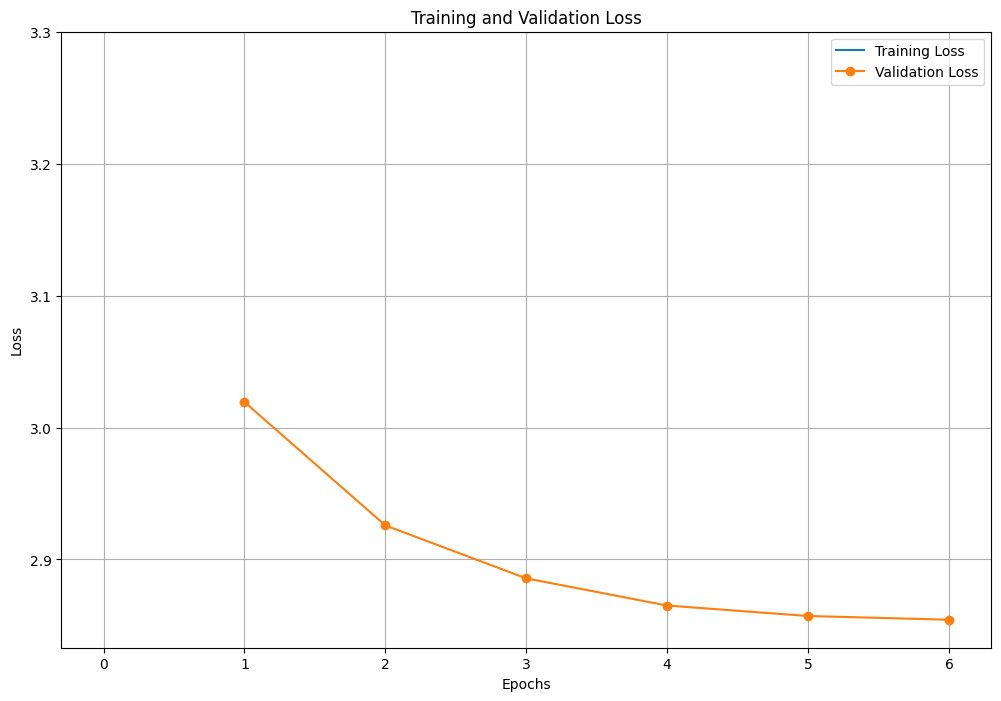

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation loss
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'runtime' not in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since validation loss is calculated at the end of each epoch,
# we'll plot it against the corresponding epochs.
epochs = range(1, len(validation_losses) + 1)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Training Steps' if len(train_losses) > len(epochs) else 'Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Modifying the hyperparameters...

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_multi_news_model_2",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_steps=200,
    eval_steps=200,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_multi_news["train"],
    eval_dataset=tokenized_multi_news["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.807188,0.141800,0.042800,0.108100,0.107900,18.973300
2,3.016900,2.791255,0.143100,0.043400,0.109300,0.109100,18.973300
3,3.016900,2.779987,0.144600,0.043800,0.110300,0.110300,18.973300
4,2.946000,2.777808,0.144800,0.043700,0.110500,0.110300,18.973300


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=1200, training_loss=2.9755343119303386, metrics={'train_runtime': 819.939, 'train_samples_per_second': 11.708, 'train_steps_per_second': 1.464, 'total_flos': 2598562588262400.0, 'train_loss': 2.9755343119303386, 'epoch': 4.0})

Some statistics:

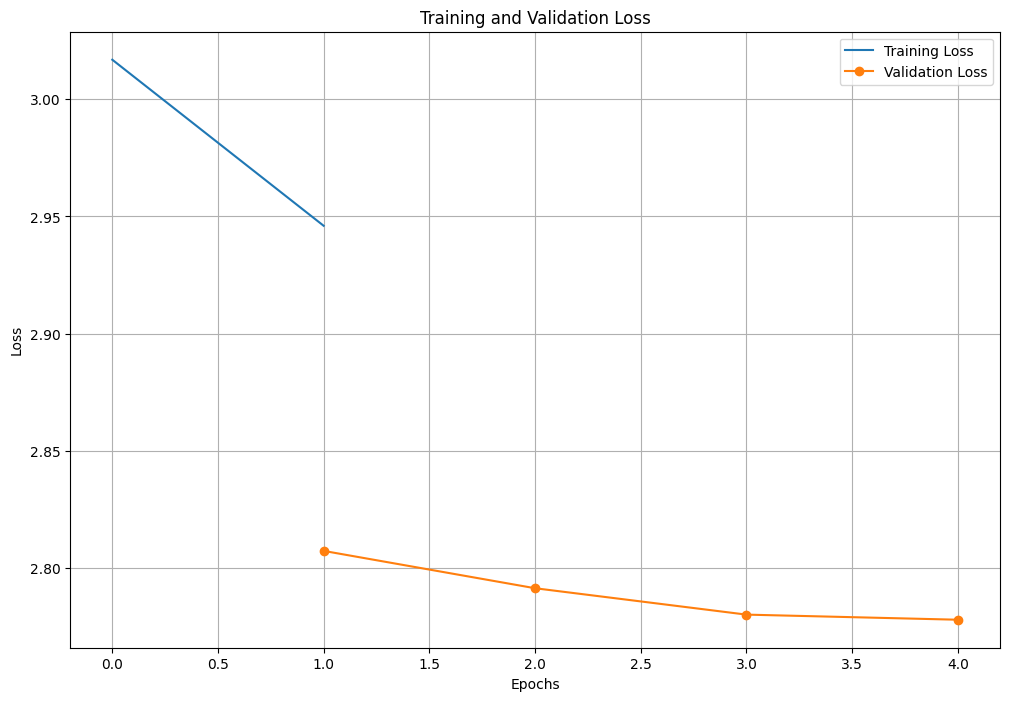

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation loss
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'runtime' not in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since validation loss is calculated at the end of each epoch,
# we'll plot it against the corresponding epochs.
epochs = range(1, len(validation_losses) + 1)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Training Steps' if len(train_losses) > len(epochs) else 'Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Step 6:** Inference with the second (modified) model **my_multi_news_model_2**

In [ ]:
import os

# Check the current working directory
print("Current Directory:", os.getcwd())

# Files in the model directory - to find out the most recent checkpoint:
model_dir = "./my_multi_news_model_2"
print("Files in model directory:", os.listdir(model_dir))

Current Directory: /content
Files in model directory: ['checkpoint-800', 'runs', 'checkpoint-1200', 'checkpoint-1000']


In [ ]:
model_dir = "./my_multi_news_model_2/checkpoint-1200"
print("Files in model directory:", os.listdir(model_dir))

Files in model directory: ['model.safetensors', 'config.json', 'tokenizer_config.json', 'rng_state.pth', 'tokenizer.json', 'spiece.model', 'trainer_state.json', 'training_args.bin', 'scheduler.pt', 'special_tokens_map.json', 'generation_config.json', 'optimizer.pt']


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "./my_multi_news_model_2/checkpoint-1200"

model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Initialize the pipeline with your trained model and tokenizer
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

sample_text = dataset['validation'][0]['document']

summary = summarizer(sample_text, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Print the original text and summary
print("Original Text:\n", sample_text)
print("\nGenerated Summary:\n", summary[0]['summary_text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (2327 > 512). Running this sequence through the model will result in indexing errors


Original Text:
 Whether a sign of a good read; or a comment on the 'pulp' nature of some genres of fiction, the Oxfam second-hand book charts have remained in The Da Vinci Code author's favour for the past four years. 
 
 Dan Brown has topped Oxfam's 'most donated' list again, his fourth consecutive year. Having sold more than 80 million copies of The Da Vinci Code and had all four of his novels on the New York Times bestseller list in the same week, it's hardly surprising that Brown's hefty tomes are being donated to charity by readers keen to make some room on their shelves. 
 
 Another cult crime writer responsible to heavy-weight hardbacks, Stieg Larsson, is Oxfam's 'most sold' author for the second time in a row. Both the 'most donated' and 'most sold' lists are dominated by crime fiction, trilogies and fantasy, with JK Rowling the only female author listed in either of the Top Fives. 
 
 Click here or on "View Gallery" to see both charts in pictures ||||| A woman reads a copy of 

Comparing the results with previous (first, unmodified) model **my_multi_news_model**

In [ ]:
# Check the current working directory
print("Current Directory:", os.getcwd())

# Files in the model directory - to find out the most recent checkpoint:
model_dir = "./my_multi_news_model"
print("Files in model directory:", os.listdir(model_dir))

Current Directory: /content
Files in model directory: ['runs', 'checkpoint-500', 'checkpoint-1000']


In [ ]:
model_dir = "./my_multi_news_model/checkpoint-1000"
print("Files in model directory:", os.listdir(model_dir))

Files in model directory: ['model.safetensors', 'config.json', 'tokenizer_config.json', 'rng_state.pth', 'tokenizer.json', 'spiece.model', 'trainer_state.json', 'training_args.bin', 'scheduler.pt', 'special_tokens_map.json', 'generation_config.json', 'optimizer.pt']


In [ ]:
model_path = "./my_multi_news_model/checkpoint-1000"

model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Initialize the pipeline with your trained model and tokenizer
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

sample_text = dataset['validation'][0]['document']

summary = summarizer(sample_text, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Print the original text and summary
print("Original Text:\n", sample_text)
print("\nGenerated Summary:\n", summary[0]['summary_text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (2327 > 512). Running this sequence through the model will result in indexing errors


Original Text:
 Whether a sign of a good read; or a comment on the 'pulp' nature of some genres of fiction, the Oxfam second-hand book charts have remained in The Da Vinci Code author's favour for the past four years. 
 
 Dan Brown has topped Oxfam's 'most donated' list again, his fourth consecutive year. Having sold more than 80 million copies of The Da Vinci Code and had all four of his novels on the New York Times bestseller list in the same week, it's hardly surprising that Brown's hefty tomes are being donated to charity by readers keen to make some room on their shelves. 
 
 Another cult crime writer responsible to heavy-weight hardbacks, Stieg Larsson, is Oxfam's 'most sold' author for the second time in a row. Both the 'most donated' and 'most sold' lists are dominated by crime fiction, trilogies and fantasy, with JK Rowling the only female author listed in either of the Top Fives. 
 
 Click here or on "View Gallery" to see both charts in pictures ||||| A woman reads a copy of 

**Step 7:** Visualization???

In [ ]:
sample_text_1 = dataset['validation'][1]['document']
sample_text_2 = dataset['validation'][2]['document']

In [ ]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
import torch

tokenizer = T5Tokenizer.from_pretrained("./my_multi_news_model_2/checkpoint-1200")
model = T5ForConditionalGeneration.from_pretrained("./my_multi_news_model_2/checkpoint-1200")

texts = [sample_text_1, sample_text_2]  # Replace with your actual texts
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Forward pass, get hidden states
with torch.no_grad():
    outputs = model(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, decoder_input_ids=inputs.input_ids)

# Extract the last layer's hidden states
hidden_states = outputs.encoder_last_hidden_state

# Process the hidden states to get embeddings, here we take the mean of the last layer's hidden states
embeddings = hidden_states.mean(dim=1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Save embeddings to .tsv file
with open("embeddings.tsv", "w") as f:
    for vec in embeddings:
        line = "\t".join([str(v) for v in vec.tolist()])
        f.write(line + "\n")

# Assuming you want to use the texts as metadata
metadata = texts

# Save metadata to .tsv file
with open("metadata.tsv", "w", encoding="utf-8") as f:
    for text in metadata:
        f.write(text + "\n")

In [ ]:
from google.colab import files
files.download('embeddings.tsv')
files.download('metadata.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Now we will switch to BART-base model and start again, completing the preprocessing and further steps:**

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("multi_news")

# Define sample size
sample_size = 3000  # Adjust this as necessary to fit within your RAM limits

# Take a random sample of the dataset
dataset_sampled = dataset["train"].shuffle(seed=42).select(range(sample_size))

# Split the sampled dataset into training and testing sets
train_test_split = dataset_sampled.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

Preprocessing:

In [ ]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

def preprocess_function(examples):
    inputs = ["summarize: " + (doc if doc is not None else "") for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length")

    # Tokenize the summaries
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")

    # Ensure no `None` values are present
    model_inputs["labels"] = [label if label is not None else tokenizer.pad_token_id for label in labels["input_ids"]]
    return model_inputs

# Re-process the datasets to ensure proper tokenization and no None values
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['document', 'summary'])
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=['document', 'summary'])

Initializing the Data Collator and the BART Model

In [ ]:
from transformers import BartForConditionalGeneration, DataCollatorForSeq2Seq

# Initialize the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Initialize the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Defining the training args

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

Evaluation:

In [ ]:
from datasets import load_metric
import numpy as np

rouge = load_metric("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    result = {key: value.mid.fmeasure for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return result

<ipython-input-32-5ce1539ce406>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Training

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.969100,2.497054,0.144430,0.048225,0.109564,0.109582,20.000000
2,2.737600,2.464984,0.144507,0.049574,0.109934,0.110050,20.000000
3,2.535100,2.448270,0.143483,0.047600,0.109824,0.109827,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=2025, training_loss=2.7122952289345825, metrics={'train_runtime': 881.6002, 'train_samples_per_second': 9.188, 'train_steps_per_second': 2.297, 'total_flos': 4938865311744000.0, 'train_loss': 2.7122952289345825, 'epoch': 3.0})

Some statistics:

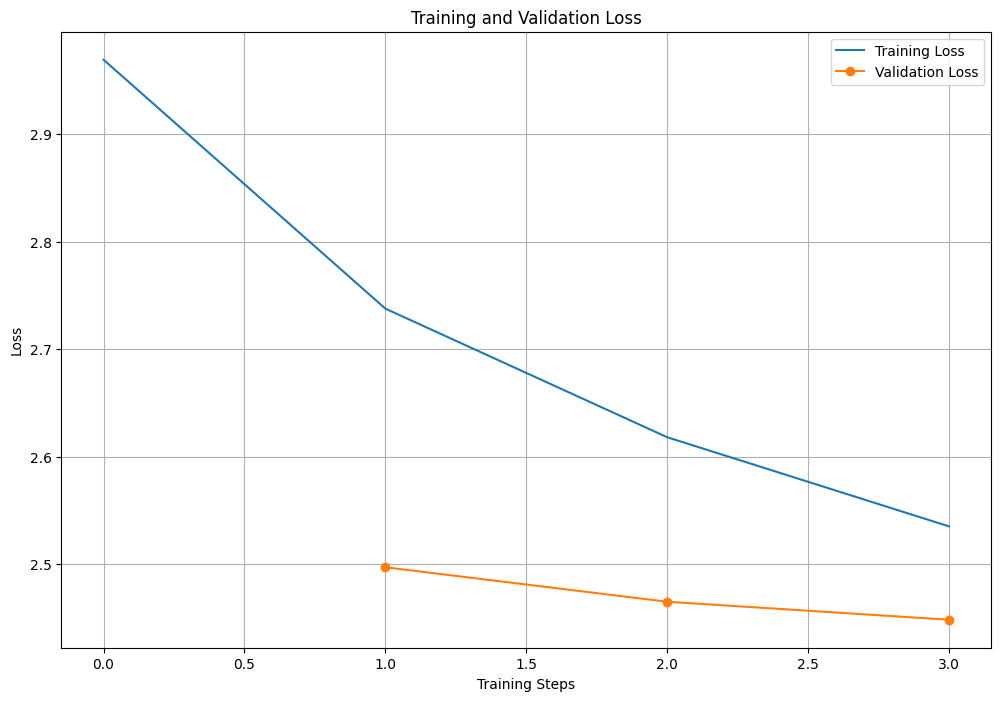

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation loss
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'runtime' not in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since validation loss is calculated at the end of each epoch,
# we'll plot it against the corresponding epochs.
epochs = range(1, len(validation_losses) + 1)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Training Steps' if len(train_losses) > len(epochs) else 'Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Modifying the parameters...

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_model_2",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.436031,0.148630,0.053318,0.113512,0.113560,20.000000
2,2.463300,2.425817,0.147618,0.050840,0.111758,0.111662,20.000000
3,2.285700,2.434585,0.147924,0.051075,0.111449,0.111430,20.000000
4,2.285700,2.450239,0.145956,0.049317,0.110726,0.110559,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=1352, training_loss=2.319727293838411, metrics={'train_runtime': 996.7917, 'train_samples_per_second': 10.835, 'train_steps_per_second': 1.356, 'total_flos': 6585153748992000.0, 'train_loss': 2.319727293838411, 'epoch': 4.0})

Some statistics:

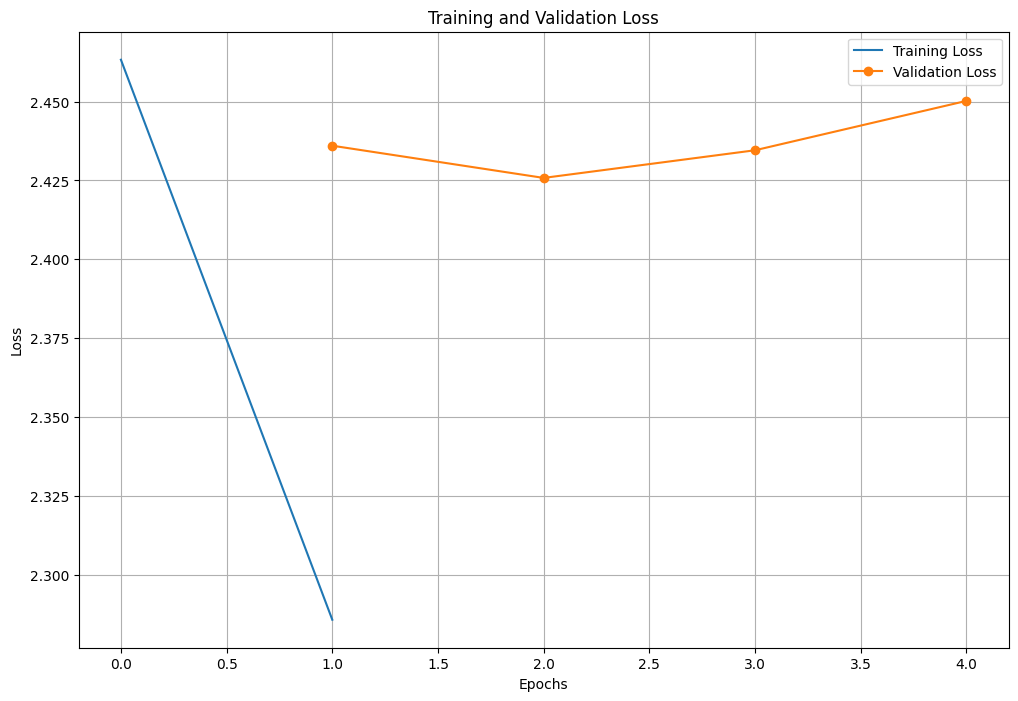

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation loss
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'runtime' not in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plotting the losses
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since validation loss is calculated at the end of each epoch,
# we'll plot it against the corresponding epochs.
epochs = range(1, len(validation_losses) + 1)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Training Steps' if len(train_losses) > len(epochs) else 'Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Inference with the second (modified) model **bart_model_2**

In [ ]:
from transformers import pipeline
import os

In [ ]:
# Check the current working directory
print("Current Directory:", os.getcwd())

# Files in the model directory - to find out the most recent checkpoint:
model_dir = "./bart_model_2"
print("Files in model directory:", os.listdir(model_dir))

Current Directory: /content
Files in model directory: ['runs', 'checkpoint-500', 'checkpoint-1000']


In [ ]:
model_dir = "./bart_model_2/checkpoint-1000"
print("Files in model directory:", os.listdir(model_dir))

Files in model directory: ['model.safetensors', 'config.json', 'vocab.json', 'merges.txt', 'tokenizer_config.json', 'rng_state.pth', 'trainer_state.json', 'training_args.bin', 'scheduler.pt', 'special_tokens_map.json', 'generation_config.json', 'optimizer.pt']


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

# Make sure you're using the correct model checkpoint
model_path = './bart_model_2/checkpoint-1000'

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

# Initialize the summarizer pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# Get a sample document from your dataset
sample_text = dataset['validation'][0]['document']

# Tokenize the text and truncate it to the appropriate length
inputs = tokenizer.encode(sample_text, return_tensors='pt', max_length=1024, truncation=True)

# Generate summary tokens
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the generated summary tokens to text
summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(f"Original Text: {sample_text}")
print(f"Generated Summary: {summary_text}")

Original Text: Whether a sign of a good read; or a comment on the 'pulp' nature of some genres of fiction, the Oxfam second-hand book charts have remained in The Da Vinci Code author's favour for the past four years. 
 
 Dan Brown has topped Oxfam's 'most donated' list again, his fourth consecutive year. Having sold more than 80 million copies of The Da Vinci Code and had all four of his novels on the New York Times bestseller list in the same week, it's hardly surprising that Brown's hefty tomes are being donated to charity by readers keen to make some room on their shelves. 
 
 Another cult crime writer responsible to heavy-weight hardbacks, Stieg Larsson, is Oxfam's 'most sold' author for the second time in a row. Both the 'most donated' and 'most sold' lists are dominated by crime fiction, trilogies and fantasy, with JK Rowling the only female author listed in either of the Top Fives. 
 
 Click here or on "View Gallery" to see both charts in pictures ||||| A woman reads a copy of t

Comparing the results with previous (first, unmodified) model **bart_model**

In [ ]:
# Check the current working directory
print("Current Directory:", os.getcwd())

# Files in the model directory - to find out the most recent checkpoint:
model_dir = "./bart_model"
print("Files in model directory:", os.listdir(model_dir))

Current Directory: /content
Files in model directory: ['checkpoint-2000', 'runs', 'checkpoint-1500', 'checkpoint-1000']


In [ ]:
model_dir = "./bart_model/checkpoint-2000"
print("Files in model directory:", os.listdir(model_dir))

Files in model directory: ['model.safetensors', 'config.json', 'vocab.json', 'merges.txt', 'tokenizer_config.json', 'rng_state.pth', 'trainer_state.json', 'training_args.bin', 'scheduler.pt', 'special_tokens_map.json', 'generation_config.json', 'optimizer.pt']


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

# Make sure you're using the correct model checkpoint
model_path = './bart_model/checkpoint-2000'

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

# Initialize the summarizer pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# Get a sample document from your dataset
sample_text = dataset['validation'][0]['document']

# Tokenize the text and truncate it to the appropriate length
inputs = tokenizer.encode(sample_text, return_tensors='pt', max_length=1024, truncation=True)

# Generate summary tokens
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the generated summary tokens to text
summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(f"Original Text: {sample_text}")
print(f"Generated Summary: {summary_text}")

Original Text: Whether a sign of a good read; or a comment on the 'pulp' nature of some genres of fiction, the Oxfam second-hand book charts have remained in The Da Vinci Code author's favour for the past four years. 
 
 Dan Brown has topped Oxfam's 'most donated' list again, his fourth consecutive year. Having sold more than 80 million copies of The Da Vinci Code and had all four of his novels on the New York Times bestseller list in the same week, it's hardly surprising that Brown's hefty tomes are being donated to charity by readers keen to make some room on their shelves. 
 
 Another cult crime writer responsible to heavy-weight hardbacks, Stieg Larsson, is Oxfam's 'most sold' author for the second time in a row. Both the 'most donated' and 'most sold' lists are dominated by crime fiction, trilogies and fantasy, with JK Rowling the only female author listed in either of the Top Fives. 
 
 Click here or on "View Gallery" to see both charts in pictures ||||| A woman reads a copy of t